# Vizualization of results

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# sns.set(rc={"figure.figsize": (20, 20)})

In [2]:
colors = sns.color_palette("Paired")

In [3]:
for i in range(0, len(colors), 2):
    r,g,b = colors[i]
    pivot = max(r,g,b)
    if r == pivot:
        colors[i] = (r, min(g*1.2, 1), min(b*1.25, 1))
    elif g == pivot:
        colors[i] = (min(r*1.2, 1), g, min(b*1.4, 1))
    else:
        colors[i] = (min(r*1.25, 1), min(g*1.1, 1), b)

In [87]:
def bar_transparent(x,y,col,data,ci='sd'):
    sns.set(font_scale=2)
    sns.set_style("whitegrid")
    col_wrap = None if col==None else 5
    
    hue_categories = ['en not significant','en', 'kr not significant', 'kr', 'svr not significant', 'svr']
    hue_categories_colors = colors

    data = data.reset_index()
    hue_column = "Models"
    data[hue_column] = data.apply(lambda row: row[x] if row["p-value"] < 0.05 else row[x]+" not significant", axis=1)
    
    palette = dict(zip(hue_categories, hue_categories_colors))
    ax = sns.catplot(
        x=x,
        y=y,
        col=col,
        col_order=['ICA_15', 'ICA_4', 'PCA_15', 'PCA_4', 'ERP'],
        hue=hue_column,
        ci=ci,
        data=data, 
        kind='bar', 
        capsize=.05,
        errwidth = 1,
        legend=False,
        col_wrap=col_wrap,
        dodge=False,
        palette=palette,
        margin_titles=True,
        sharex=True, 
        sharey=True,
        height=5, 
        aspect=1,
    ).set_titles("Pipeline: {col_name}").set_axis_labels("", "Internal $R^2$").set_xticklabels(["SVR", "KR-rbf", "EN"])
    
    ax.savefig("rumination_prediction_summary.png")

    return ax

In [6]:
file_name_ICA = "../../data/results_regression/regression_ICA_visualization_error.pkl"
results_ICA = pd.read_pickle(file_name_ICA)

file_name_PCA = "../../data/results_regression/regression_PCA_visualization_error.pkl"
results_PCA = pd.read_pickle(file_name_PCA)

file_name_ERP = "../../data/results_regression/regression_ERP_visualization_error.pkl"
results_ERP = pd.read_pickle(file_name_ERP)

In [ ]:
results_df = pd.concat([results_ICA, results_PCA, results_ERP], ignore_index=True)

In [61]:
file_name = "../../data/results_regression/regression_results_without_functions_visualization_error.pkl"
results_df = pd.read_pickle(file_name)

In [62]:
# results_df['pipeline_name'] = results_df['pipeline_name'].apply(lambda x: x[:-5])

In [43]:
# results_df

For plotting error bars - hack

In [63]:
duplicates=10000

#duplicate observations to get good std bars
dfCopy = results_df.loc[results_df.index.repeat(duplicates)].copy()
dfCopy['mean_cv_r2'] = np.random.normal(dfCopy['mean_cv_r2'].values,dfCopy['std_cv_r2'].values)
dfCopy['mean_cv_mae'] = np.random.normal(dfCopy['mean_cv_mae'].values,dfCopy['std_cv_mae'].values)

### Pipelines vs Models

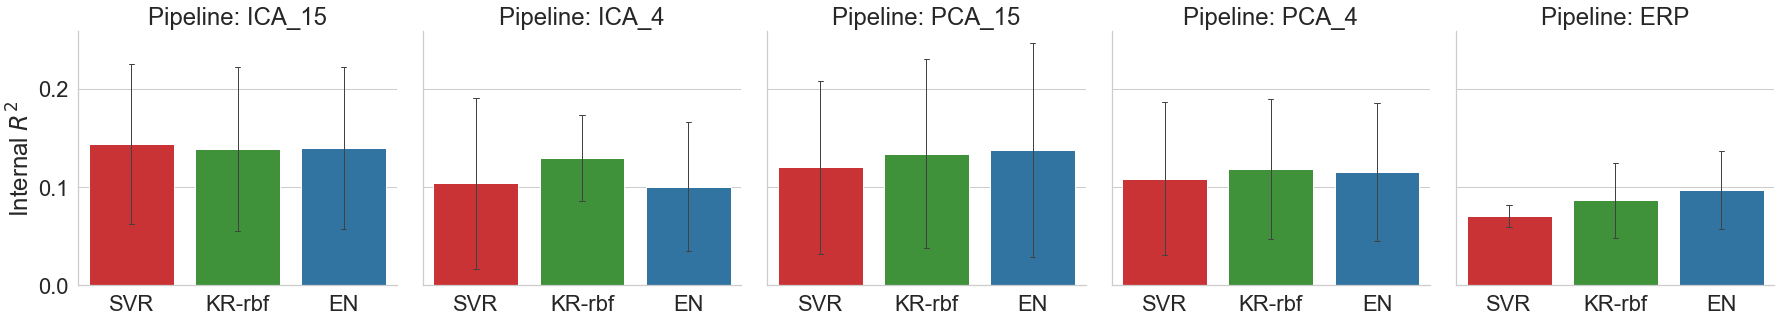

In [88]:
bar_transparent(x="model", y="mean_cv_r2", col="pipeline_name", ci='sd', data=dfCopy)

In [ ]:
mean_train_mae_list = []
for index, row in results_df.iterrows():
    cv_results_params = row.cv_results['params']
    params = row.parameters
        
    index = cv_results_params.index(params)
    mean_train_mae = row.cv_results['mean_train_neg_mean_absolute_error'][index]
    mean_train_mae_list.append(abs(mean_train_mae))

    print(mean_train_mae)
mean_train_mae_list = np.array(mean_train_mae_list)
mean_train_mae_df = pd.DataFrame(mean_train_mae_list)
results_df['mean_train_mae'] = mean_train_mae_df

In [ ]:
results_df.head()

In [ ]:
# summarize_df = results_df[results_df['p-value'] <= 0.06]
summarize_df = results_df
summarize_df = summarize_df[["data_set", "mean_cv_r2", "mean_train_r2", "mean_cv_mae", "mean_train_mae", "pipeline_name", "model", "std_cv_r2", "std_cv_mae", "p-value", 'parameters', "external_test_r2", "external_test_correlation", "internal_correlation"]]
summarize_df = summarize_df.reset_index()
columns_order = ["data_set", "pipeline_name", "model", "mean_train_r2", "mean_cv_r2", "std_cv_r2", "mean_train_mae", "mean_cv_mae", "std_cv_mae", "internal_correlation", "p-value", "external_test_r2", "external_test_correlation", 'parameters']
summarize_df = summarize_df[columns_order].rename(columns = {'mean_train_r2': 'mean train R2', 'mean_cv_r2': 'mean test R2', "std_cv_r2": "R2 std", 'mean_train_mae': 'mean train MAE', 'mean_cv_mae': 'mean test MAE', "std_cv_mae": "MAE std", "external_test_r2" : "External validation R2", "external_test_correlation" : "External validation r", "internal_correlation" : 'r'}, inplace = False)

summarize_df['# spatial filter components'] = summarize_df['parameters'].apply(lambda x: x['ica__n_components'] if x.get('ica__n_components') is not None else (x['spatial_filter__n_components'] if x.get('spatial_filter__n_components') is not None else '-' ))
summarize_df['# selected features'] = summarize_df['parameters'].apply(lambda x: x['feature_selection__n_components'])
summarize_df = summarize_df.drop(columns=['parameters'])

In [ ]:
summarize_df["p-value"] = pd.to_numeric(summarize_df["p-value"])

In [ ]:
summarize_df = summarize_df.round({'mean train R2': 3, 'mean test R2': 3, 'R2 std': 3, 'mean train MAE': 3, 'mean test MAE': 3, 'MAE std': 3, 'p-value': 3,
                                  "External validation R2" : 3, 'External validation r' : 3, 'r' : 3})

In [ ]:
summarize_df

In [ ]:
summarize_df.to_csv(
    "regression_summary.csv"
)

-----------------------------

Permutation test results

In [ ]:
permutation_scores = results_df['permutation_scores'].to_numpy()
scores = results_df['mean_cv_r2'].to_numpy()

In [ ]:
test = permutation_scores[14]
test_score = scores[14]

In [ ]:
# sns.set(rc={"figure.figsize": (40, 20)})
sns.set_style("whitegrid")
ax = sns.displot(test, bins=30, height=8.27, aspect=11.7/8.27, palette = sns.color_palette("Paired"))
ax.set(xlabel='Accuracy score', ylabel='Count')

score_label = (f"Score on original\ndata: {test_score:.3f}")

plt.text(0.0001, 111.7, score_label, fontsize=12, bbox=dict(facecolor='blue', alpha=0.1, edgecolor='black', linewidth=2))
plt.axvline(test_score, ls='--', color='r')

# ax.savefig("probalility_distribution_ERP_en.png")